Advanced implementation of MLEnd Code

In [1]:
#required dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

import zipfile
import sklearn
import random

In [80]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
sample_path = '/home/jovyan/ML/DATA/DATA_unzip_full/*.wav'
files = glob.glob(sample_path)
len(files)

2500

In [81]:
MLENDLS_df = pd.read_csv('/home/jovyan/ML/git-code/MLEndLS_final.csv').set_index('file_id') 
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


In [88]:
MLENDLS_df['in_out'].value_counts()

outdoor    1319
indoor     1181
Name: in_out, dtype: int64

In [20]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [5]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    

    
    try:
        
        fs = None # if None, fs would be 22050 #fr = sr = sampling rate
        x, fs = librosa.load(file,sr=fs)

        if scale_audio: 
            #x = x/np.max(np.abs(x))
            x = sklearn.preprocessing.minmax_scale(x, axis=0)
            x = librosa.effects.preemphasis(x)

        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        #yi = labels_file.loc[fileID]['in_out']=='indoor'
        y1 = labels_file.loc[fileID]['in_out']
        y2 = labels_file.loc[fileID]['area']
        y3 = labels_file.loc[fileID]['spot']
        yi = [ y1, y2, y3 ]

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        mfccs = librosa.feature.mfcc(y = x, sr=fs)
        spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=fs)[0]

        rmse = librosa.feature.rms(y=x)
        chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)
        spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
        rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
        zcr = librosa.feature.zero_crossing_rate(x)

        xi = [power,pitch_mean,pitch_std,voiced_fr, np.mean(np.mean(mfccs.T,axis=0)), np.mean(spectral_centroids), np.mean(rmse), np.mean(chroma_stft), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
        X.append(xi)
        y.append(yi)
        
    except:
        print('issue in file index -->' + str(file))
      
    

  return np.array(X),np.array(y)

In [6]:
sample_file = random.sample(files, 500)

In [7]:
X,y = getXy(sample_file, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

  1%|▏         | 7/500 [00:24<23:35,  2.87s/it]  /opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
  3%|▎         | 17/500 [01:14<33:03,  4.11s/it]  /opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
  4%|▍         | 20/500 [01:37<58:09,  7.27s/it]/opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
  4%|▍         | 21/500 [01:51<1:13:10,  9.17s/it]/opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
  5%|▌         | 26/500 [02:26<53:04,  6.72s/it]  /opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to est

In [26]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (500, 11)
The shape of y is (500, 3)


In [11]:
df1 = pd.DataFrame.from_records(X)
df1

,0,1,2,3,4,5,6,7,8,9,10
0,0.000375,131.176203,14.302356,0.025733,-13.329107,3059.435736,0.017930,0.777882,3109.872941,6450.418947,0.043074
1,0.000331,0.000000,0.000000,0.000000,-12.342485,3559.897865,0.017945,0.680987,3390.693027,7563.722072,0.018859
2,0.000186,175.941351,27.252490,0.057047,-15.457408,2352.233607,0.013413,0.736039,3207.815917,5742.307932,0.003223
3,0.000287,309.914699,142.885866,0.085670,-17.621130,3329.585607,0.016475,0.727327,4092.946321,7197.556997,0.015092
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024
...,...,...,...,...,...,...,...,...,...,...,...
495,0.000261,0.000000,0.000000,0.000000,-14.940593,3592.805387,0.015756,0.678571,3280.529532,6879.689450,0.031320
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.015450,0.523873,4972.494530,9925.377446,0.031623
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.013996,0.750911,5023.997690,13233.885213,0.066853
498,0.000264,212.369938,3.307037,0.006360,-16.526691,1803.725438,0.016202,0.896750,2832.025479,4810.068794,0.001093


In [12]:
df2 = pd.DataFrame.from_records(y)
df2

,0,1,2
0,outdoor,british,street
1,outdoor,british,street
2,outdoor,Euston,forecourt
3,indoor,british,greatcourt
4,outdoor,westend,trafalgar
...,...,...,...
495,outdoor,southbank,skate
496,indoor,campus,ground
497,outdoor,campus,canal
498,outdoor,campus,square


In [14]:
df3 = df1.join(df2, lsuffix="_x", rsuffix="_y")
df3

,0_x,1_x,2_x,3,4,5,6,7,8,9,10,0_y,1_y,2_y
0,0.000375,131.176203,14.302356,0.025733,-13.329107,3059.435736,0.017930,0.777882,3109.872941,6450.418947,0.043074,outdoor,british,street
1,0.000331,0.000000,0.000000,0.000000,-12.342485,3559.897865,0.017945,0.680987,3390.693027,7563.722072,0.018859,outdoor,british,street
2,0.000186,175.941351,27.252490,0.057047,-15.457408,2352.233607,0.013413,0.736039,3207.815917,5742.307932,0.003223,outdoor,Euston,forecourt
3,0.000287,309.914699,142.885866,0.085670,-17.621130,3329.585607,0.016475,0.727327,4092.946321,7197.556997,0.015092,indoor,british,greatcourt
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024,outdoor,westend,trafalgar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000261,0.000000,0.000000,0.000000,-14.940593,3592.805387,0.015756,0.678571,3280.529532,6879.689450,0.031320,outdoor,southbank,skate
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.015450,0.523873,4972.494530,9925.377446,0.031623,indoor,campus,ground
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.013996,0.750911,5023.997690,13233.885213,0.066853,outdoor,campus,canal
498,0.000264,212.369938,3.307037,0.006360,-16.526691,1803.725438,0.016202,0.896750,2832.025479,4810.068794,0.001093,outdoor,campus,square


In [16]:
df3.to_csv('feature-set-3-adv.csv')

In [84]:
df_adv = pd.read_csv('/home/jovyan/ML/git-code/feature-set-3-adv.csv').set_index('id') 
df_adv

,0_x,1_x,2_x,3,4,5,6,7,8,9,10,0_y,1_y,2_y
id,,,,,,,,,,,,,,
0,0.000375,131.176203,14.302356,0.025733,-13.329107,3059.435736,0.017930,0.777882,3109.872941,6450.418947,0.043074,outdoor,british,street
1,0.000331,0.000000,0.000000,0.000000,-12.342485,3559.897865,0.017945,0.680987,3390.693027,7563.722072,0.018859,outdoor,british,street
2,0.000186,175.941351,27.252490,0.057047,-15.457408,2352.233607,0.013413,0.736039,3207.815917,5742.307932,0.003223,outdoor,Euston,forecourt
3,0.000287,309.914699,142.885866,0.085670,-17.621130,3329.585607,0.016475,0.727327,4092.946321,7197.556997,0.015092,indoor,british,greatcourt
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024,outdoor,westend,trafalgar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000261,0.000000,0.000000,0.000000,-14.940593,3592.805387,0.015756,0.678571,3280.529532,6879.689450,0.031320,outdoor,southbank,skate
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.015450,0.523873,4972.494530,9925.377446,0.031623,indoor,campus,ground
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.013996,0.750911,5023.997690,13233.885213,0.066853,outdoor,campus,canal


In [86]:
df_adv['2_y'].value_counts()

square        49
library       33
canal         31
ground        30
piazza        30
market        29
charing       28
reception     23
curve         23
forecourt     22
greatcourt    21
trafalgar     20
room12        20
national      15
leicester     14
street        14
gardens       12
food          11
skate         10
upper         10
waterloo       8
albert         7
royal          7
marine         7
book           6
bridge         6
hintze         4
dinosaur       3
ritblat        3
cromwell       2
pond           2
Name: 2_y, dtype: int64

In [6]:
df_adv['1_y'].value_counts()

campus        155
westend       126
british        90
Euston         56
southbank      48
kensington     25
Name: 1_y, dtype: int64

In [56]:
options = ['campus', 'westend']
df_1 = df_adv.loc[df_adv['1_y'].isin(options)]
df_1


,0_x,1_x,2_x,3,4,5,6,7,8,9,10,0_y,1_y,2_y
id,,,,,,,,,,,,,,
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024,outdoor,westend,trafalgar
5,0.000359,223.066313,16.486602,0.064516,-13.796000,3793.996894,0.018799,0.659943,3892.835085,7537.940871,0.007134,outdoor,campus,library
6,0.000294,107.124887,4.316667,0.007680,-12.570039,3888.809442,0.016928,0.574885,3124.727707,6756.530368,0.068887,indoor,campus,ground
9,0.000407,157.463614,17.007877,0.094891,-13.282209,5407.634543,0.019580,0.531427,5316.760678,11794.191164,0.043565,indoor,campus,curve
12,0.000262,107.733564,7.531924,0.053665,-13.283175,2589.037085,0.016130,0.803570,3509.981424,5951.732248,0.001232,outdoor,campus,square
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.000214,161.544807,11.197348,0.061813,-13.571802,1851.583611,0.014394,0.794493,3147.037241,3975.153527,0.004070,outdoor,campus,square
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.015450,0.523873,4972.494530,9925.377446,0.031623,indoor,campus,ground
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.013996,0.750911,5023.997690,13233.885213,0.066853,outdoor,campus,canal


In [57]:
X = df_1.drop(['1_y', '2_y'], axis=1)
print(X['0_y'].value_counts())

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(X['0_y'])
print(list(le.classes_))
X['0_y'] = le.transform(X['0_y'])

# le.fit(X['2_y'])
# print(list(le.classes_))
# X['2_y'] = le.transform(X['2_y'])



X

indoor     148
outdoor    133
Name: 0_y, dtype: int64
['indoor', 'outdoor']


,0_x,1_x,2_x,3,4,5,6,7,8,9,10,0_y
id,,,,,,,,,,,,
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024,1
5,0.000359,223.066313,16.486602,0.064516,-13.796000,3793.996894,0.018799,0.659943,3892.835085,7537.940871,0.007134,1
6,0.000294,107.124887,4.316667,0.007680,-12.570039,3888.809442,0.016928,0.574885,3124.727707,6756.530368,0.068887,0
9,0.000407,157.463614,17.007877,0.094891,-13.282209,5407.634543,0.019580,0.531427,5316.760678,11794.191164,0.043565,0
12,0.000262,107.733564,7.531924,0.053665,-13.283175,2589.037085,0.016130,0.803570,3509.981424,5951.732248,0.001232,1
...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.000214,161.544807,11.197348,0.061813,-13.571802,1851.583611,0.014394,0.794493,3147.037241,3975.153527,0.004070,1
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.015450,0.523873,4972.494530,9925.377446,0.031623,0
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.013996,0.750911,5023.997690,13233.885213,0.066853,1


In [58]:
# X = df_1.drop(['1_y', '0_y', '2_y'], axis=1)
y = df_1['1_y']
y

id
4      westend
5       campus
6       campus
9       campus
12      campus
        ...   
493     campus
496     campus
497     campus
498     campus
499     campus
Name: 1_y, Length: 281, dtype: object

In [59]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

list(le.classes_)
#le.transform(['british', 'campus', 'westend'])

['campus', 'westend']

In [60]:
y_n = le.transform(y)
len(y_n)

281

In [61]:
corr = X.corr()
X.head()

,0_x,1_x,2_x,3,4,5,6,7,8,9,10,0_y
id,,,,,,,,,,,,
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.013749,0.676671,3360.657703,5913.497575,0.009024,1
5,0.000359,223.066313,16.486602,0.064516,-13.796000,3793.996894,0.018799,0.659943,3892.835085,7537.940871,0.007134,1
6,0.000294,107.124887,4.316667,0.007680,-12.570039,3888.809442,0.016928,0.574885,3124.727707,6756.530368,0.068887,0
9,0.000407,157.463614,17.007877,0.094891,-13.282209,5407.634543,0.019580,0.531427,5316.760678,11794.191164,0.043565,0
12,0.000262,107.733564,7.531924,0.053665,-13.283175,2589.037085,0.016130,0.803570,3509.981424,5951.732248,0.001232,1


In [62]:
#import statsmodels.formula.api as sm
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [63]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [64]:
selected_columns = X.columns[columns]
selected_columns.shape

(10,)

In [65]:
X = X[selected_columns]
X

,0_x,1_x,2_x,3,4,5,7,8,10,0_y
id,,,,,,,,,,
4,0.000196,212.983535,53.891787,0.063467,-16.661283,2897.988063,0.676671,3360.657703,0.009024,1
5,0.000359,223.066313,16.486602,0.064516,-13.796000,3793.996894,0.659943,3892.835085,0.007134,1
6,0.000294,107.124887,4.316667,0.007680,-12.570039,3888.809442,0.574885,3124.727707,0.068887,0
9,0.000407,157.463614,17.007877,0.094891,-13.282209,5407.634543,0.531427,5316.760678,0.043565,0
12,0.000262,107.733564,7.531924,0.053665,-13.283175,2589.037085,0.803570,3509.981424,0.001232,1
...,...,...,...,...,...,...,...,...,...,...
493,0.000214,161.544807,11.197348,0.061813,-13.571802,1851.583611,0.794493,3147.037241,0.004070,1
496,0.000244,320.124468,8.893479,0.029499,-13.765862,4511.764935,0.523873,4972.494530,0.031623,0
497,0.000203,159.385457,13.077490,0.042895,-15.161199,7131.167778,0.750911,5023.997690,0.066853,1


In [66]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(X.values, y_n, SL, selected_columns.values)

In [67]:
X = pd.DataFrame(data = data_modeled, columns = selected_columns)
X

,3,4,7,8,10
0,0.063467,-16.661283,0.676671,3360.657703,0.009024
1,0.064516,-13.796000,0.659943,3892.835085,0.007134
2,0.007680,-12.570039,0.574885,3124.727707,0.068887
3,0.094891,-13.282209,0.531427,5316.760678,0.043565
4,0.053665,-13.283175,0.803570,3509.981424,0.001232
...,...,...,...,...,...
276,0.061813,-13.571802,0.794493,3147.037241,0.004070
277,0.029499,-13.765862,0.523873,4972.494530,0.031623
278,0.042895,-15.161199,0.750911,5023.997690,0.066853
279,0.006360,-16.526691,0.896750,2832.025479,0.001093


In [68]:
len(X)
X

,3,4,7,8,10
0,0.063467,-16.661283,0.676671,3360.657703,0.009024
1,0.064516,-13.796000,0.659943,3892.835085,0.007134
2,0.007680,-12.570039,0.574885,3124.727707,0.068887
3,0.094891,-13.282209,0.531427,5316.760678,0.043565
4,0.053665,-13.283175,0.803570,3509.981424,0.001232
...,...,...,...,...,...
276,0.061813,-13.571802,0.794493,3147.037241,0.004070
277,0.029499,-13.765862,0.523873,4972.494530,0.031623
278,0.042895,-15.161199,0.750911,5023.997690,0.066853
279,0.006360,-16.526691,0.896750,2832.025479,0.001093


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y_n,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((196, 5), (85, 5), (196,), (85,))

In [70]:
X_train

,3,4,7,8,10
196,0.103916,-12.884877,0.721834,4234.500838,0.013367
163,0.043091,-12.868086,0.602556,3726.657748,0.007334
83,0.000000,-13.042526,0.580704,3983.449993,0.013482
68,0.052186,-11.080527,0.612671,3957.431839,0.021120
26,0.000000,-14.286487,0.665389,4941.465013,0.079336
...,...,...,...,...,...
5,0.041401,-12.864397,0.501506,2936.511821,0.048585
58,0.000000,-11.011518,0.659702,4717.875511,0.355623
233,0.034653,-13.357521,0.816742,4817.223588,0.000599
155,0.065015,-13.525846,0.669717,3048.935358,0.035928


In [71]:
from keras import layers
from keras import layers
import keras
from keras.models import Sequential

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier = model.fit(X_train, y_train, epochs = 100, batch_size = 128)

Epoch 1/100
2/2 [==============================] - 1s 12ms/step - loss: 276.5389 - accuracy: 0.1888
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 69.3619 - accuracy: 0.4898
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 17.5348 - accuracy: 0.5612
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 24.7859 - accuracy: 0.5612
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 42.7141 - accuracy: 0.4388
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 23.4060 - accuracy: 0.4694
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 39.5420 - accuracy: 0.5612
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 19.4492 - accuracy: 0.4898
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 20.8366 - accuracy: 0.2959
Epoch 10/100
2/2 [==============================] - 0s 7ms/step - loss: 6.0786 - accuracy: 0.5612
Epoch 11/100
2/2 [

In [73]:
test_loss, test_acc = model.evaluate(X_val,y_val)

3/3 [==============================] - 1s 7ms/step - loss: 4.6855 - accuracy: 0.4706


In [74]:
from sklearn import svm

model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)
# print(y_train)
# print(yt_p)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5612244897959183
Validation  Accuracy 0.5294117647058824


In [75]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

# print(yv_p)
# print(y_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.923469387755102
Validation  Accuracy 0.5882352941176471


Training Accuracy 0.923469387755102
Validation  Accuracy 0.5882352941176471


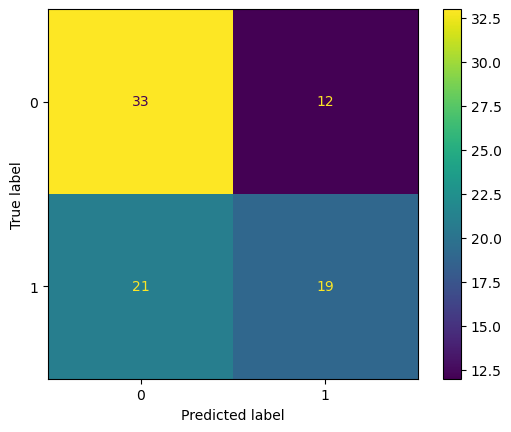

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr.fit(X_train,y_train)

yt_p1 = model.predict(X_train)
yv_p1 = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

plot_confusion_matrix(logisticRegr, X_val, y_val)  
plt.show()

In [77]:
from xgboost import XGBClassifier

params = {
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 2.0,
            'n_estimators':100
        }

modelXGB = XGBClassifier(**params)
modelXGB.fit(X_train, y_train)


yt_p1 = modelXGB.predict(X_train)
yv_p1 = modelXGB.predict(X_val)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

Training Accuracy 0.7295918367346939
Validation  Accuracy 0.611764705882353


In [78]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

yt_p1 = neigh.predict(X_train)
yv_p1 = neigh.predict(X_val)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

Training Accuracy 0.7806122448979592
Validation  Accuracy 0.6235294117647059


In [79]:
from sklearn.tree import DecisionTreeClassifier

dtf = DecisionTreeClassifier(splitter = 'best', )
dtf.fit(X_train, y_train)

yt_p1 = dtf.predict(X_train)
yv_p1 = dtf.predict(X_val)


print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.5294117647058824
